# Training the model on images

## Imports

In [1]:
# load custom scripts
from dataset_images import Dataset
import config 

# import the necessary packages
from torch.nn import CrossEntropyLoss 
from torch.optim import Adam
from torch.utils.data import DataLoader
from skimage import io
from sklearn.model_selection import train_test_split
from torchvision import transforms, models
from imutils import paths
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import segmentation_models_pytorch as smp
import torch
import time
import os

## Setup CUDA

In [2]:
print(f"Is CUDA supported by this system? {torch.cuda.is_available()}")
print(f"[INFO] CUDA version: {torch.version.cuda}")
  
# storing ID of current CUDA device
cuda_id = torch.cuda.current_device()
print(f"[INFO] ID of current CUDA device:{torch.cuda.current_device()}")
        
print(f"[INFO] Name of current CUDA device:{torch.cuda.get_device_name(cuda_id)}")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Is CUDA supported by this system? True
[INFO] CUDA version: 11.1
[INFO] ID of current CUDA device:0
[INFO] Name of current CUDA device:NVIDIA GeForce RTX 3090


## Load images

In [3]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(list(paths.list_images(config.IMAGE_DATASET_PATH)))
maskPaths = sorted(list(paths.list_images(config.MASK_DATASET_PATH)))

# partition the data into training and validation
split = train_test_split(imagePaths[:-10], maskPaths[:-10], test_size=config.VAL_SPLIT, random_state=42)
# unpack the data split
(trainImages, valImages) = split[:2]
(trainMasks, valMasks) = split[2:]

# save 10 testing images to disk
testImages = imagePaths[-10:]
testMasks = maskPaths[-10:]
print("[INFO] saving testing image paths...")
f = open(config.TEST_PATHS, "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


## Example

In [4]:
# new label classes
classes = {0: 'hard coral',
           1: 'hard coral bleached',
           2: 'soft coral',
           3: 'dead coral',
           4: 'other invertebrates',
           5: 'sand/rubble',
           6: 'other',
           7: 'algae',
           8: 'unknown'
          }

In [5]:
image = io.imread(trainImages[1])
mask = io.imread(trainMasks[1])

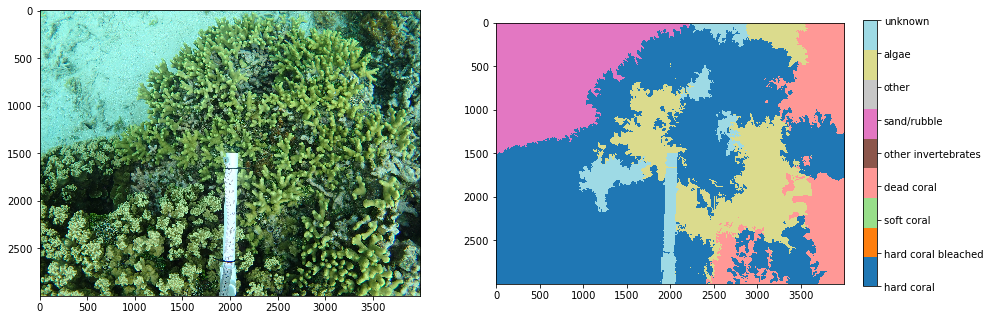

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 15))
ax[0].imshow(image)
cax = ax[1].imshow(mask, cmap = plt.cm.get_cmap('tab20', 9), vmin=0, vmax=8)
cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035, pad=0.05)
cbar.ax.set_yticklabels(list(classes.values()))
plt.show()

## Transforms

In [7]:
train_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33)),    
    A.HorizontalFlip(p=0.5),              
    A.RandomRotate90(p=0.5),
    #A.OpticalDistortion(distort_limit=2, shift_limit=0.5, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5),
    A.CLAHE(p=0.8),
    A.RandomBrightnessContrast(p=0.8),    
    A.RandomGamma(p=0.8),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

In [8]:
val_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33)),    
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])

## Create dataset

In [9]:
# create the train and validation datasets
startTime = time.time()
trainDS = Dataset(imagePaths=trainImages, maskPaths=trainMasks, transform=train_transform)
valDS = Dataset(imagePaths=valImages, maskPaths=valMasks, transform=val_transform)
print(f"[INFO] found {len(trainDS)} examples in the training set")
print(f"[INFO] found {len(valDS)} examples in the validation set")
print(f"[INFO] found 10 examples in the test set")
endTime = time.time()
print("[INFO] total time taken to load the data: {:.2f}s".format(endTime - startTime))

[INFO] found 2718 examples in the training set
[INFO] found 480 examples in the validation set
[INFO] found 10 examples in the test set
[INFO] total time taken to load the data: 0.00s


In [10]:
# create the training and validation data loaders
trainLoader = DataLoader(trainDS, shuffle=True, 
                         batch_size=config.BATCH_SIZE, 
                         pin_memory=config.PIN_MEMORY, 
                         num_workers=os.cpu_count(),
                         persistent_workers=True)

valLoader = DataLoader(valDS, shuffle=False, 
                       batch_size=config.BATCH_SIZE, 
                       pin_memory=config.PIN_MEMORY, 
                       num_workers=os.cpu_count(),
                       persistent_workers=True)

In [11]:
print(f"[INFO] batch_size:{config.BATCH_SIZE}")
print(f"[INFO] num_workers:{os.cpu_count()}")

[INFO] batch_size:128
[INFO] num_workers:32


In [12]:
sample = valDS[0]
print(f"Feature shape: {sample[0].shape}")
print(f"Labels shape: {sample[1].shape}")


Feature shape: torch.Size([3, 128, 128])
Labels shape: torch.Size([128, 128])


## Model initialization

In [16]:
# import a pretrained model
model = smp.Unet(
    encoder_name="resnet18",
    encoder_weights="imagenet",
    in_channels=3,      
    classes=9
)

In [17]:
unet = model.to(config.DEVICE)

# initialize loss function
lossFunc = CrossEntropyLoss(ignore_index=8)

# initialize optimizer
opt = Adam(unet.parameters(), lr=config.INIT_LR)

# calculate steps per epoch for training and validation set
trainSteps = len(trainDS) // config.BATCH_SIZE
valSteps = len(valDS) // config.BATCH_SIZE

# initialize a dictionary to store training history
H = {"train_loss": [], "validation_loss": []}

## Training loop

In [18]:
# loop over epochs

unnormalize = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                  transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ])])

print("[INFO] training the network...")
startTime = time.time()
for e in tqdm(range(config.NUM_EPOCHS)):
    # set the model in training mode
    unet.train()

    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalValLoss = 0
    
    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
        # send the input to the device
        (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
        
        # perform a forward pass 
        pred = unet(x)
        # calculate the training loss
        loss = lossFunc(pred, y)
        
        # zero out any previously accumulated gradients
        opt.zero_grad()
        # perform backpropagation
        loss.backward()
        # update model parameters
        opt.step()

        # add the loss to the total training loss so far
        totalTrainLoss += loss.item()
        
    
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        unet.eval()
        
        # loop over the validation set
        for (x, y) in valLoader:
            # send the input to the device
            (x, y) = (x.to(config.DEVICE), y.to(config.DEVICE))
            
            # make the predictions 
            pred = unet(x)
            # calculate the validation loss
            totalValLoss += lossFunc(pred, y).item()
            
            # show the validation results
            fig, ax = plt.subplots(ncols=3, figsize=(10, 10))
            ax[0].imshow(unnormalize(x[0]).cpu().detach().permute(1, 2, 0))
            ax[1].imshow(y[0].cpu(), cmap = plt.cm.get_cmap('tab20', 9), vmin=0, vmax=8)
            cax = ax[2].imshow(torch.argmax(pred[0],dim=0).cpu(),
                               cmap = plt.cm.get_cmap('tab20', 9), vmin=0, vmax=8)
            cbar = fig.colorbar(cax, ticks=list(classes.keys()), fraction=0.035)
            cbar.ax.set_yticklabels(list(classes.values()))
            plt.show()
            
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgValLoss = totalValLoss / valSteps
    
    # update our training history
    H["train_loss"].append(avgTrainLoss)
    H["validation_loss"].append(avgValLoss)
    
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, config.NUM_EPOCHS))
    print("Train loss: {:.6f}, Validation loss: {:.4f}".format(avgTrainLoss, avgValLoss))
    
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(endTime - startTime))

[INFO] training the network...


  0%|                                                                                                                             | 0/40 [00:05<?, ?it/s]


RuntimeError: DataLoader worker (pid(s) 1233560, 1233592, 1233627, 1233659, 1233691, 1233726, 1233758, 1233790, 1233825, 1233857, 1233889, 1233924, 1233956, 1233988, 1234023, 1234055, 1234087, 1234122, 1234154, 1234186, 1234221, 1234253, 1234285, 1234320, 1234352, 1234384, 1234419, 1234451, 1234483, 1234518, 1234550, 1234582) exited unexpectedly

## Plotting the errors

In [ ]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["validation_loss"], label="validation_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.ylim((0,7))
plt.legend(loc="upper right")
plt.savefig(config.PLOT_PATH)

# Save model

In [ ]:
# serialize the model to disk
torch.save(unet, config.MODEL_PATH)
print("[INFO] model saved !")